In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Inbound Labour forecast

In [7]:
file_path = r"C:\Users\langsi\Desktop\APPY\calculated inLabour.xlsx"
df = pd.read_excel(file_path)

df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [8]:
df.head()

,Calculated Labour
date,
2022-08-01,4
2022-08-02,5
2022-08-03,3
2022-08-04,6
2022-08-05,5


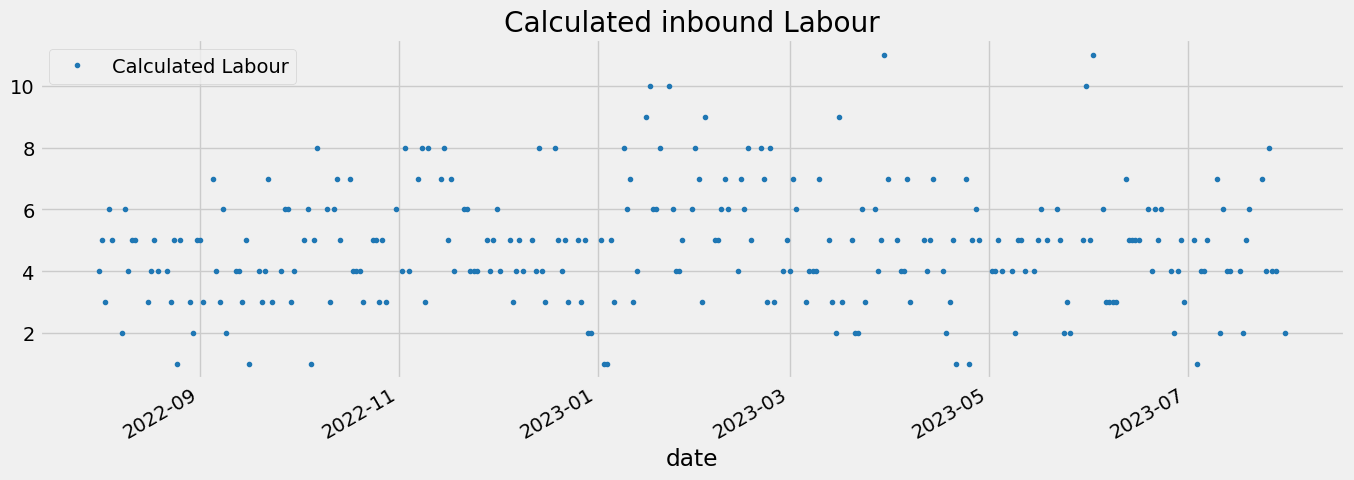

In [9]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Calculated inbound Labour')
plt.show()

# Train/ Test split

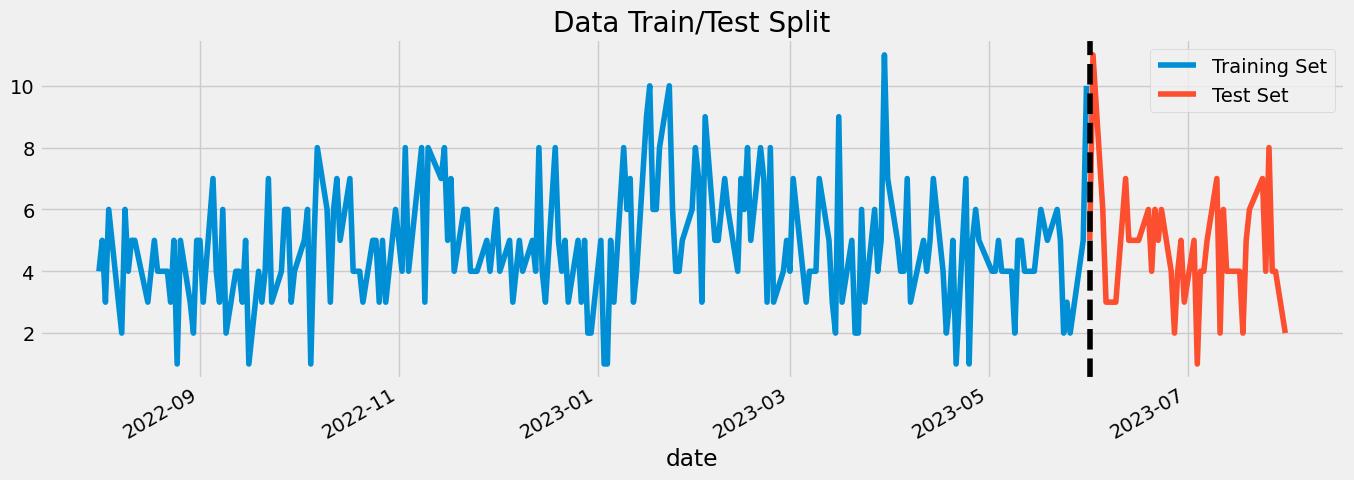

In [12]:
train = df.loc[df.index < '06-01-2023']
test = df.loc[df.index >= '06-01-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('06-01-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Feature Creation

In [14]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

C:\Users\langsi\AppData\Local\Temp\ipykernel_19796\430284916.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='dayofweek', y='Calculated Labour', palette='Blues')


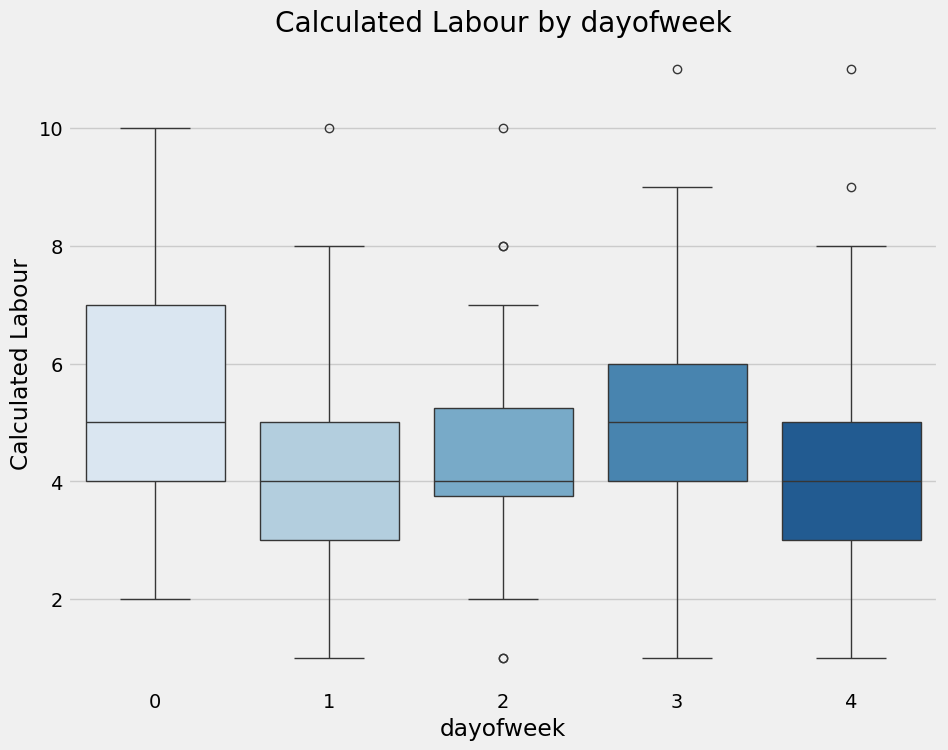

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Calculated Labour', palette='Blues')
ax.set_title('Calculated Labour by dayofweek')
plt.show()

# Creation of the model

In [17]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear',  'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Calculated Labour'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [18]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:45:25] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.66892	validation_1-rmse:4.46835
[100]	validation_0-rmse:2.33177	validation_1-rmse:2.46557
[200]	validation_0-rmse:1.70275	validation_1-rmse:1.97526
[300]	validation_0-rmse:1.53611	validation_1-rmse:1.86671
[400]	validation_0-rmse:1.45917	validation_1-rmse:1.84903
[426]	validation_0-rmse:1.44211	validation_1-rmse:1.84875


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

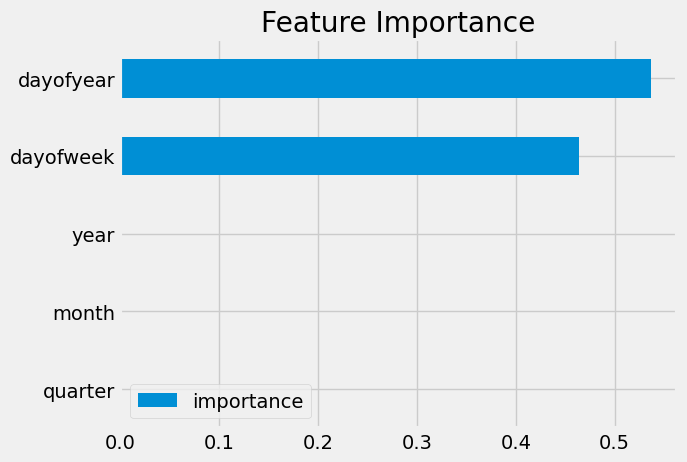

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on test data

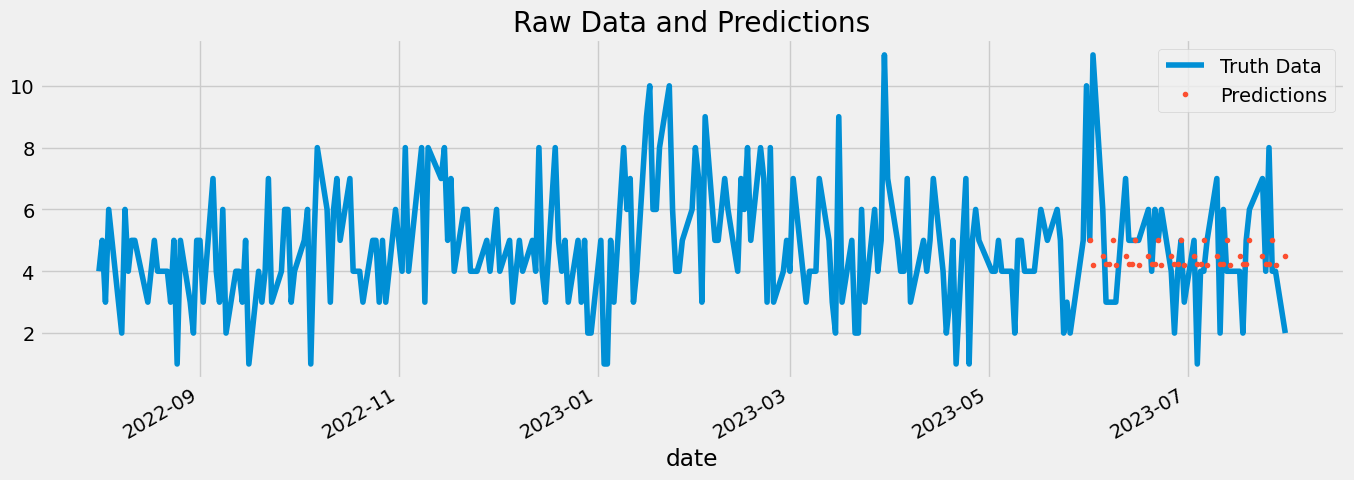

In [22]:
# Predictions
test['prediction'] = reg.predict(X_test)

# Merging
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
df['Calculated Labour'].plot(ax=ax, label='Truth Data')
df['prediction'].plot(ax=ax, style='.', label='Predictions')
ax.set_title('Raw Data and Predictions')
plt.legend()
plt.show()

# SCore (RMSE)

In [24]:
score = np.sqrt(mean_squared_error(test['Calculated Labour'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1.85


# Error Calculation

In [27]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['Date'] = test.index.date
test.groupby(['Date'])['error'].mean().sort_values(ascending=False).head(10)

Date
2023-06-02    6.806565
2023-07-26    3.753659
2023-07-04    3.246341
2023-07-10    2.511329
2023-07-24    2.511329
2023-06-12    2.511329
2023-07-31    2.488671
2023-06-27    2.246341
2023-07-11    2.246341
2023-07-18    2.246341
Name: error, dtype: float64

# Addition of other features

# Lag features

In [39]:
def add_lags(df):
    target_map = df['Calculated Labour'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('120 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('180 days')).map(target_map)
    return df

In [40]:
df = add_lags(df)

# Train using cross Validation

In [41]:
from sklearn.model_selection import TimeSeriesSplit


In [44]:
tss = TimeSeriesSplit(n_splits=3, test_size=60*1, gap=20)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Calculated Labour'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[22:17:45] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.06651	validation_1-rmse:5.02401


[100]	validation_0-rmse:2.01784	validation_1-rmse:2.97474
[200]	validation_0-rmse:1.37994	validation_1-rmse:2.62627
[297]	validation_0-rmse:1.16649	validation_1-rmse:2.61865
[22:17:46] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.33079	validation_1-rmse:4.81247
[100]	validation_0-rmse:2.07323	validation_1-rmse:3.01236
[200]	validation_0-rmse:1.39574	validation_1-rmse:2.42737
[300]	validation_0-rmse:1.18999	validation_1-rmse:2.31759
[400]	validation_0-rmse:1.09952	validation_1-rmse:2.23780
[500]	validation_0-rmse:1.04952	validation_1-rmse:2.07854
[600]	validation_0-rmse:1.00079	validation_1-rmse:2.01133
[700]	validation_0-rmse:0.95049	validation_1-rmse:1.99136
[729]	validation_0-rmse:0.93722	validation_1-rmse:1.98922
[22:17:49] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is n

In [51]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2.1778
Fold scores:[2.6056279315123665, 1.988796506521163, 1.9390177044023595]


# Predicting the feature

Retraining on all data

To Predict the future we need an emtpy dataframe for future date ranges.

Run those dates through our feature creation code + lag creation

In [52]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear',  'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Calculated Labour'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[22:22:53] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.63603
[100]	validation_0-rmse:2.31395
[200]	validation_0-rmse:1.67101
[300]	validation_0-rmse:1.49973
[400]	validation_0-rmse:1.43196
[499]	validation_0-rmse:1.38544


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [53]:
# get the highest date
df.index.max()

Timestamp('2023-07-31 00:00:00')

In [55]:

# Create future dataframe
future = pd.date_range('2023-07-01', '2024-03-31', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

# Concatenate DataFrames
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

# Exclude weekends
df_and_future = df_and_future[~df_and_future.index.dayofweek.isin([5, 6])]  # 5 and 6 correspond to Saturday and Sunday

# Assuming create_features and add_lags are functions you've defined elsewhere
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)


In [56]:
future_w_features = df_and_future.query('isFuture').copy()

# Predict the feature

In [58]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

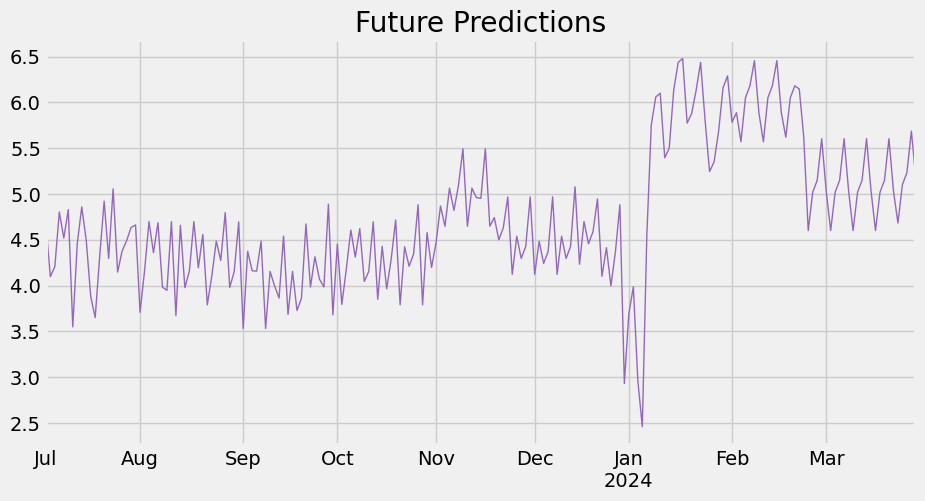

In [59]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [60]:
# Save model
reg.save_model('model.json')

<Axes: title={'center': 'Future Predictions'}>

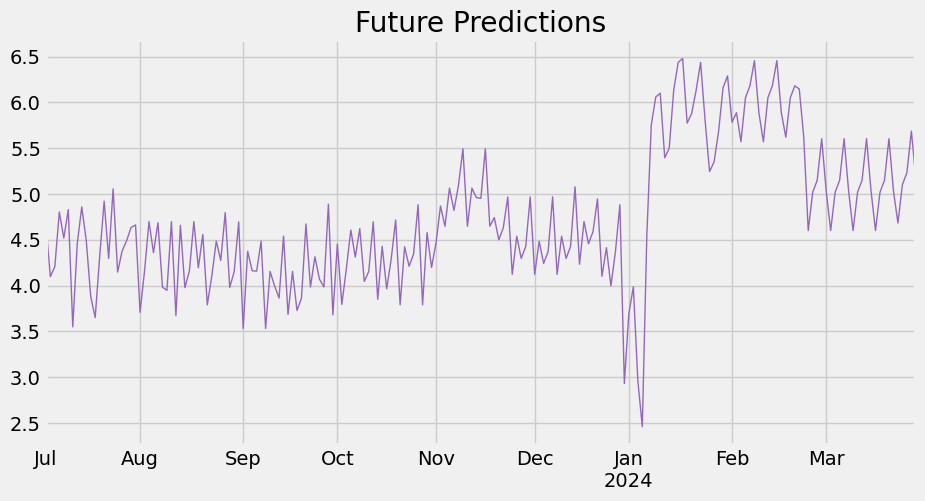

In [61]:
#  Running the saved model
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

In [63]:
future_w_features.head()

,Calculated Labour,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,prediction_y,prediction,lag1,lag2,lag3,isFuture,pred
2023-07-03,NaN,NaN,0,3,7,2023,184,3,27,NaN,NaN,NaN,5.0,NaN,1.0,True,4.677587
2023-07-04,NaN,NaN,1,3,7,2023,185,4,27,NaN,NaN,NaN,4.0,3.0,5.0,True,4.097061
2023-07-05,NaN,NaN,2,3,7,2023,186,5,27,NaN,NaN,NaN,NaN,4.0,3.0,True,4.207541
2023-07-06,NaN,NaN,3,3,7,2023,187,6,27,NaN,NaN,NaN,NaN,4.0,NaN,True,4.803761
2023-07-07,NaN,NaN,4,3,7,2023,188,7,27,NaN,NaN,NaN,4.0,4.0,NaN,True,4.518885


In [67]:
future_w_features.to_csv(r'C:\Users\langsi\Desktop\APPY\inbound forecasted labour.csv', index=True)



# Outbound Labour forecast

In [69]:
file_path1 = r"C:\Users\langsi\Desktop\APPY\Calculated outboundlabour.xlsx"
df1 = pd.read_excel(file_path1)

df1 = df1.set_index('Processed_date')
df1.index = pd.to_datetime(df1.index)

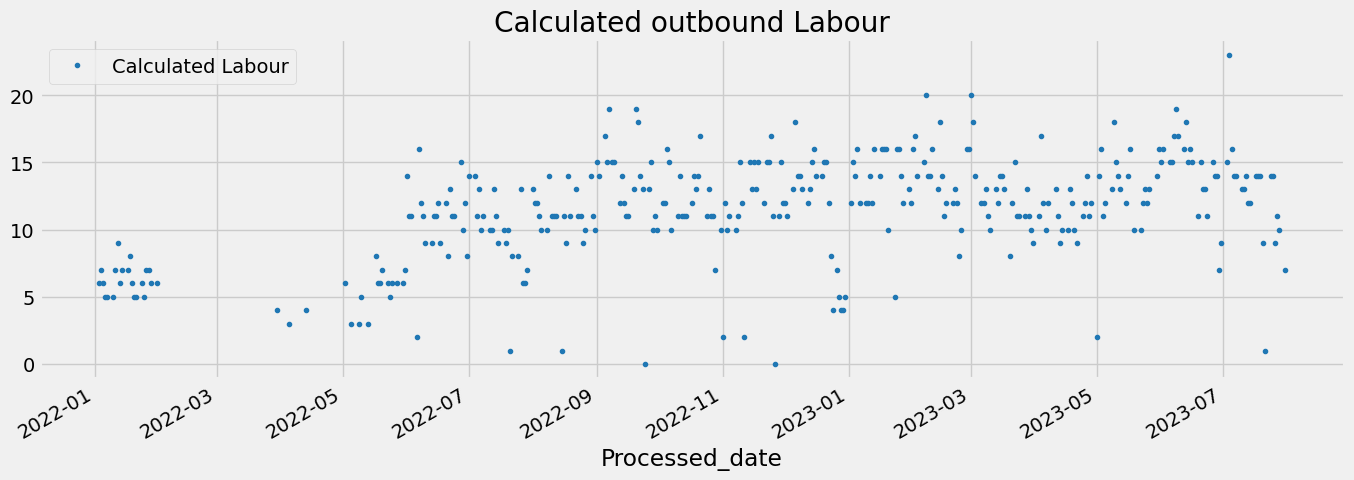

In [71]:
df1.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Calculated outbound Labour')
plt.show()

# Train/test split

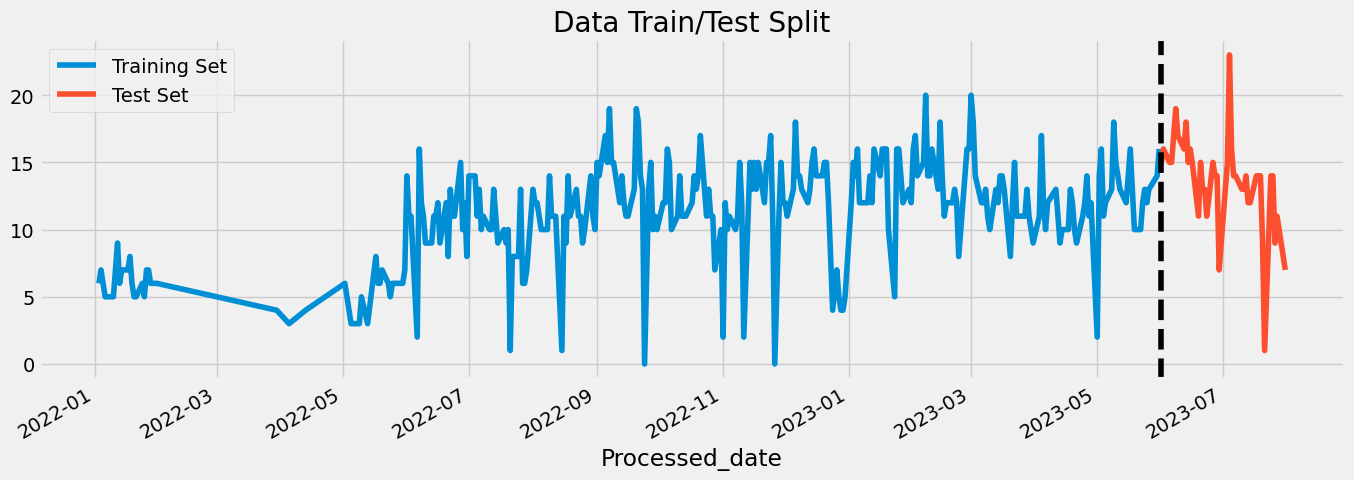

In [74]:
train1 = df1.loc[df1.index < '06-01-2023']
test1 = df1.loc[df1.index >= '06-01-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train1.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test1.plot(ax=ax, label='Test Set')
ax.axvline('06-01-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Feature Creation

In [75]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df1 = create_features(df1)

C:\Users\langsi\AppData\Local\Temp\ipykernel_19796\911309794.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df1, x='dayofweek', y='Calculated Labour', palette='Blues')


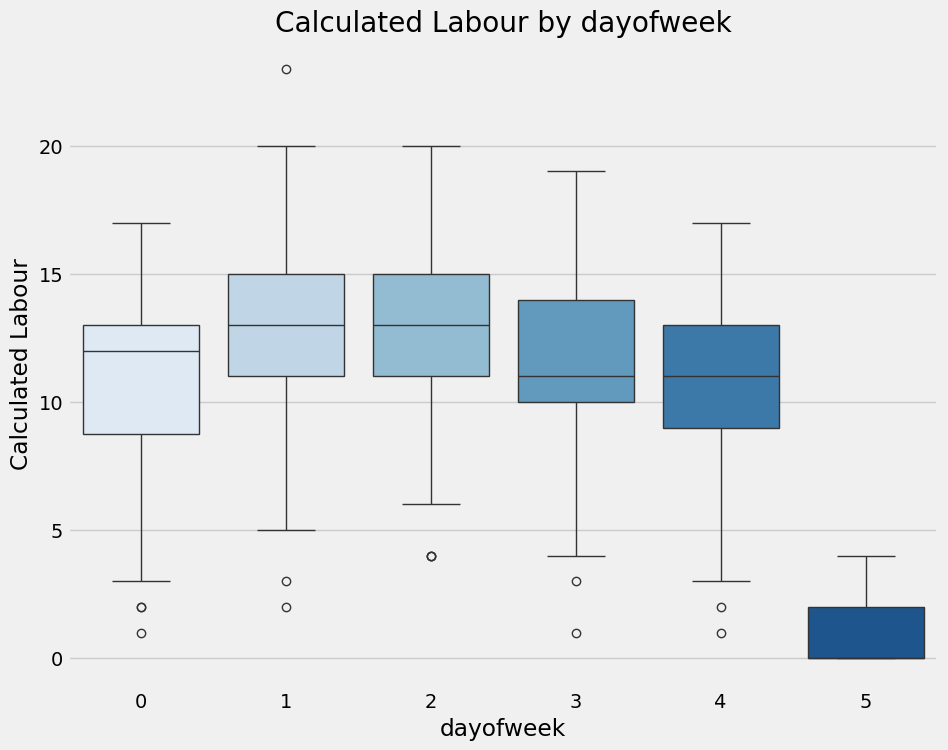

In [76]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df1, x='dayofweek', y='Calculated Labour', palette='Blues')
ax.set_title('Calculated Labour by dayofweek')
plt.show()

In [78]:
# Adding lag features.  60 days period was considered between lags
def add_lags(df1):
    target_map = df1['Calculated Labour'].to_dict()
    df1['lag1'] = (df1.index - pd.Timedelta('60 days')).map(target_map)
    df1['lag2'] = (df1.index - pd.Timedelta('120 days')).map(target_map)
    df1['lag3'] = (df1.index - pd.Timedelta('180 days')).map(target_map)
    return df1

In [79]:
df1 = add_lags(df1)

In [85]:
tss = TimeSeriesSplit(n_splits=3, test_size=60*1, gap=20)
df1 = df1.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Calculated Labour'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[23:08:31] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.05398	validation_1-rmse:12.64982


[100]	validation_0-rmse:4.34202	validation_1-rmse:7.98060
[200]	validation_0-rmse:2.52839	validation_1-rmse:6.94611
[300]	validation_0-rmse:1.97877	validation_1-rmse:6.68935
[367]	validation_0-rmse:1.81843	validation_1-rmse:6.75306
[23:08:32] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.53696	validation_1-rmse:11.94756
[100]	validation_0-rmse:4.56074	validation_1-rmse:5.02064
[200]	validation_0-rmse:2.71078	validation_1-rmse:3.32571
[300]	validation_0-rmse:2.21204	validation_1-rmse:3.15333
[400]	validation_0-rmse:2.01922	validation_1-rmse:3.04567
[500]	validation_0-rmse:1.90749	validation_1-rmse:2.96365
[600]	validation_0-rmse:1.83662	validation_1-rmse:2.95267
[613]	validation_0-rmse:1.82711	validation_1-rmse:2.95064
[23:08:35] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is

In [86]:
# printing validation score
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 4.2403
Fold scores:[6.6816396789075, 2.9501962647035196, 3.08899079918304]


In [87]:
# Retrain on all data
df1 = create_features(df1)

FEATURES = ['dayofyear',  'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Calculated Labour'

X_all = df1[FEATURES]
y_all = df1[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[23:08:58] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.50726


[100]	validation_0-rmse:4.93929
[200]	validation_0-rmse:2.95918
[300]	validation_0-rmse:2.43518
[400]	validation_0-rmse:2.24187
[499]	validation_0-rmse:2.12900


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [83]:
df1.index.max()

Timestamp('2023-07-31 00:00:00')

# Future prediction

In [88]:
# Create future dataframe
future = pd.date_range('2023-07-01', '2024-03-31', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

# Concatenate DataFrames
df1['isFuture'] = False
df_and_future = pd.concat([df1, future_df])

# Exclude weekends
df_and_future = df_and_future[~df_and_future.index.dayofweek.isin([5, 6])]  # 5 and 6 correspond to Saturday and Sunday

# Assuming create_features and add_lags are functions you've defined elsewhere
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [89]:
future_w_features = df_and_future.query('isFuture').copy()

In [90]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

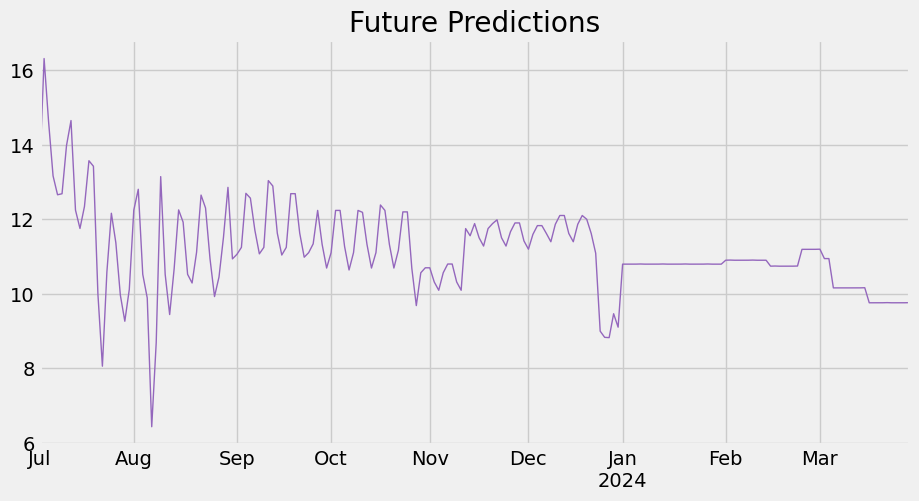

In [91]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [92]:
future_w_features.to_csv(r'C:\Users\langsi\Desktop\APPY\outbound forecasted labour.csv', index=True)
